In [8]:
#Tratamiento de Datos
import pandas as pd
import numpy as np

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score, log_loss, silhouette_score, silhouette_samples
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import shap
import lime
from lime import lime_tabular
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

import warnings
warnings.filterwarnings("ignore")

In [32]:
datos = pd.read_csv('../data/processed/sleep.csv')
df=datos.copy()
X_train = pd.read_csv('../data/processed/X_train_raw.csv')
X_test = pd.read_csv('../data/processed/X_test_raw.csv')
X_train_pca = pd.read_csv('../data/processed/X_train_pca.csv')
X_test_pca =  ('../data/processed/X_test_pca.csv')

## Análisis No Supervisado con datos PCA

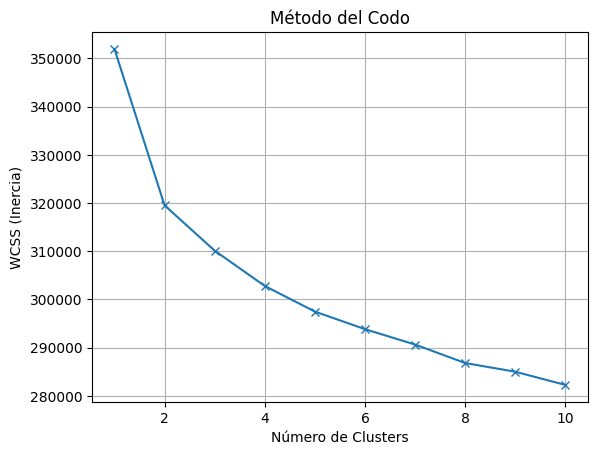

In [3]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_train_pca)
    wcss.append(kmeans.inertia_)

plt.figure()
plt.plot(range(1, 11), wcss, marker = 'x')  # Número de clusters en el eje X
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS (Inercia)')
plt.grid(True)
plt.show()

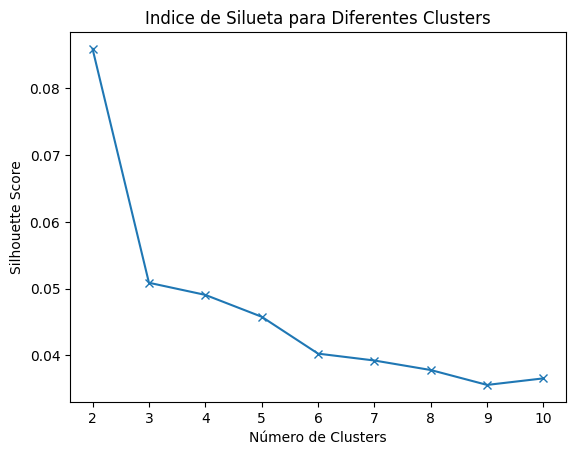

In [5]:
sil_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_train_pca)
    sil_scores.append(silhouette_score(X_train_pca, labels))

plt.figure()
plt.plot(range(2, 11), sil_scores, marker='x')  # Número de clusters en el eje X
plt.title('Indice de Silueta para Diferentes Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

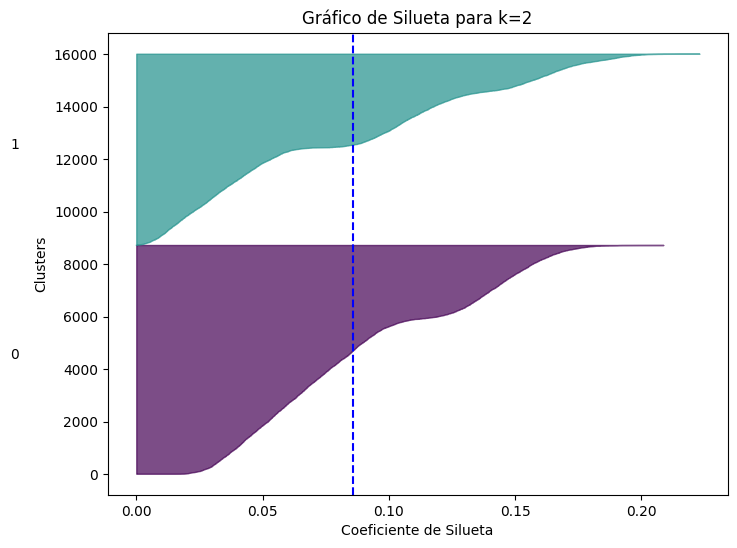

In [26]:
def plot_silhouette(X_train_pca, n_clusters):
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Ajustar KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_train_pca)

    # Obtener valores de silueta
    sil_values = silhouette_samples(X_train_pca, cluster_labels)
    avg_sil = silhouette_score(X_train_pca, cluster_labels)

    # Crear el gráfico
    y_lower = 10
    cmap = plt.get_cmap('viridis')

    for i in range(n_clusters):
        cluster_sil_values = sil_values[cluster_labels == i]
        cluster_sil_values.sort()  # Ordenar los valores de silueta
        size_cluster = cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster  # Definir el valor superior de y para cada cluster

        # Área de la silueta para este cluster
        color = cmap(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_sil_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))  # Etiqueta del cluster

        # Actualizar y_lower para el siguiente cluster
        y_lower = y_upper + 10

    # Dibujar una línea vertical que marque el valor promedio de la silueta
    ax.axvline(avg_sil, color='blue', linestyle="--")

    # Títulos y etiquetas
    ax.set_title(f"Gráfico de Silueta para k={n_clusters}")
    ax.set_xlabel("Coeficiente de Silueta")
    ax.set_ylabel("Clusters")
    
    plt.show()

# Llamar a la función con el conjunto de datos y número de clusters
plot_silhouette(X_train_pca, n_clusters=2)

In [33]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters=kmeans.fit_predict(X_train_pca)

X_train_clusters = X_train.copy()
X_train_clusters['cluster'] = clusters

X_train_clusters

,Age,Sleep duration,Stress level,Heart rate,Daily steps,Physical activity,Height,Weight,Average screen time,Gender_F,...,Alcohol consumption_Y,Smoking_Y,Medical issue_Y,Ongoing medication_Y,Smart device before bed_Y,Blue-light filter_Y,Blood Pressure,BMI,BMI Category,cluster
0,36,1,1,83,1000,91,153,63,9.6,0,...,1,0,1,1,1,0,3,26.9,2,1
1,32,1,5,88,20000,179,157,63,9.3,1,...,0,1,1,0,0,0,3,25.6,2,1
2,36,2,1,100,12000,17,153,63,5.4,0,...,0,0,1,1,1,0,1,26.9,2,1
3,25,2,4,62,7000,174,153,83,7.3,1,...,1,0,0,1,0,0,1,35.5,4,1
4,39,3,4,81,12000,71,199,79,2.5,0,...,1,0,1,1,1,1,4,19.9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,26,1,4,82,17000,158,158,52,3.2,1,...,1,0,1,1,1,0,1,20.8,1,0
15996,43,3,2,87,18000,34,166,54,6.9,1,...,0,1,1,1,1,1,0,19.6,1,0
15997,25,2,2,71,11000,78,160,88,1.7,1,...,0,1,1,0,0,0,3,34.4,3,1
15998,21,0,5,100,19000,31,192,79,7.1,1,...,0,1,1,0,1,0,0,21.4,1,0
